# VC Dimension and PAC Learning: A Comprehensive Guide

## Introduction

This notebook explores two fundamental concepts in statistical learning theory:
- **VC Dimension (Vapnik-Chervonenkis Dimension)**: A measure of the capacity or complexity of a hypothesis class
- **PAC Learning (Probably Approximately Correct)**: A framework for analyzing learning algorithms

We'll explore their definitions, provide intuitive explanations, demonstrate them with code, and show how they're deeply connected.

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from itertools import product
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

## Part 1: VC Dimension

### Definition

The **VC Dimension** of a hypothesis class $\mathcal{H}$ is the size of the largest set of points that can be **shattered** by $\mathcal{H}$.

**Shattering**: A set of points $S$ is shattered by $\mathcal{H}$ if for every possible labeling of the points in $S$, there exists a hypothesis $h \in \mathcal{H}$ that produces that labeling.

### Key Insights

- VC dimension measures the **expressive power** of a hypothesis class
- Higher VC dimension = more complex model = higher capacity
- It's about the **worst case**: we need to find at least one configuration that can be shattered

### Example 1: Linear Classifiers in 2D

A linear classifier in 2D has VC dimension = 3. Let's visualize this:

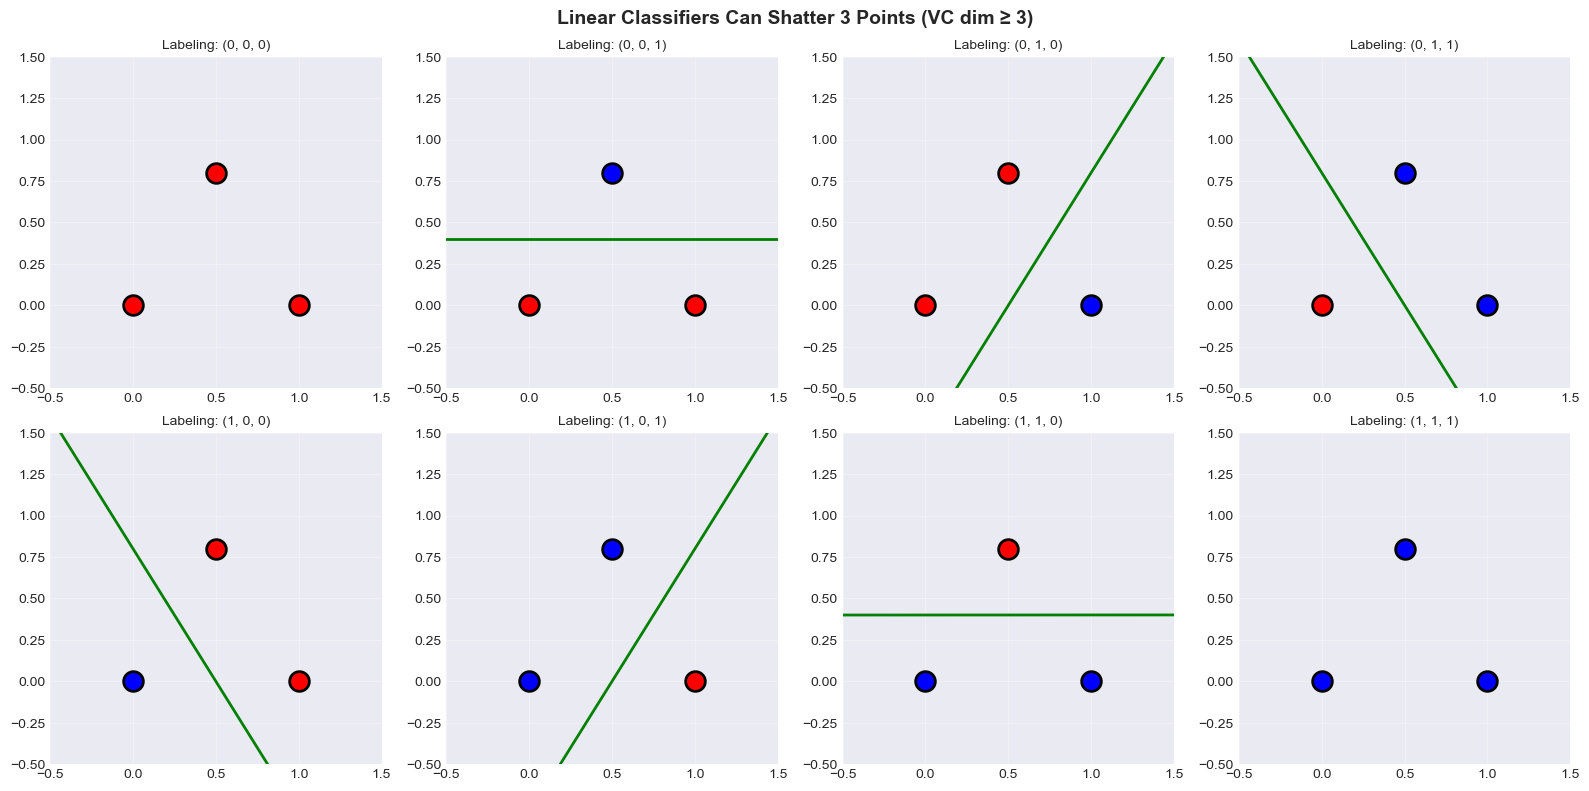

In [2]:
def plot_line(ax, w, b, xlim, color='black', label=None):
    """Plot a decision boundary line: w[0]*x + w[1]*y + b = 0"""
    x = np.array(xlim)
    if abs(w[1]) > 1e-10:
        y = -(w[0] * x + b) / w[1]
        ax.plot(x, y, color=color, linewidth=2, label=label)
    else:
        ax.axvline(-b/w[0], color=color, linewidth=2, label=label)

def visualize_shattering_3_points():
    """Demonstrate that 3 points can be shattered by linear classifiers in 2D"""
    # Three points in general position (not collinear)
    points = np.array([[0, 0], [1, 0], [0.5, 0.8]])
    
    # All 8 possible labelings
    # Cartesian product of all 3-tuples of {0, 1}.
    labelings = list(product([0, 1], repeat=3))
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for idx, labels in enumerate(labelings):
        ax = axes[idx]
        
        # Plot points
        colors = ['red' if l == 0 else 'blue' for l in labels]
        for i, (point, color) in enumerate(zip(points, colors)):
            ax.scatter(point[0], point[1], c=color, s=200, edgecolors='black', linewidth=2, zorder=3)
        
        # Find a separating line using SVM (if not all same label)
        if len(set(labels)) > 1:
            clf = SVC(kernel='linear', C=1000)
            clf.fit(points, labels)
            
            # Plot decision boundary
            w = clf.coef_[0]
            b = clf.intercept_[0]
            plot_line(ax, w, b, [-0.5, 1.5], color='green')
        
        ax.set_xlim(-0.5, 1.5)
        ax.set_ylim(-0.5, 1.5)
        ax.set_aspect('equal')
        ax.set_title(f'Labeling: {labels}', fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Linear Classifiers Can Shatter 3 Points (VC dim ≥ 3)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_shattering_3_points()

**Observation**: Every possible labeling of 3 points can be separated by a line!

Now let's show that 4 points **cannot** always be shattered:

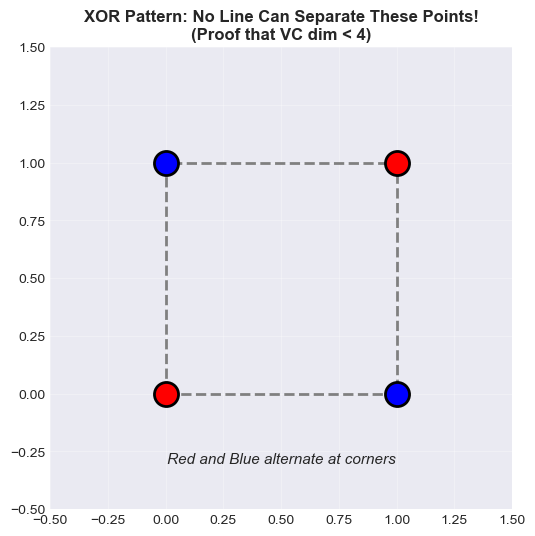

In [3]:
def visualize_no_shattering_4_points():
    """Show that 4 points cannot always be shattered (XOR problem)"""
    # Four points forming a square
    points = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])
    
    # XOR labeling: opposite corners have same label
    labels = [0, 1, 0, 1]
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # Plot points
    colors = ['red' if l == 0 else 'blue' for l in labels]
    for point, color, label in zip(points, colors, labels):
        ax.scatter(point[0], point[1], c=color, s=300, edgecolors='black', linewidth=2, zorder=3)
    
    # Draw the square
    square = Rectangle((0, 0), 1, 1, fill=False, edgecolor='gray', linewidth=2, linestyle='--')
    ax.add_patch(square)
    
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-0.5, 1.5)
    ax.set_aspect('equal')
    ax.set_title('XOR Pattern: No Line Can Separate These Points!\n(Proof that VC dim < 4)', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.text(0.5, -0.3, 'Red and Blue alternate at corners', ha='center', fontsize=11, style='italic')
    
    plt.show()

visualize_no_shattering_4_points()

**Conclusion**: Linear classifiers in 2D have **VC dimension = 3**

### General Formula

For linear classifiers in $d$ dimensions:

$$\text{VC-dim} = d + 1$$

This includes the bias term.

### Example 2: VC Dimensions of Common Hypothesis Classes

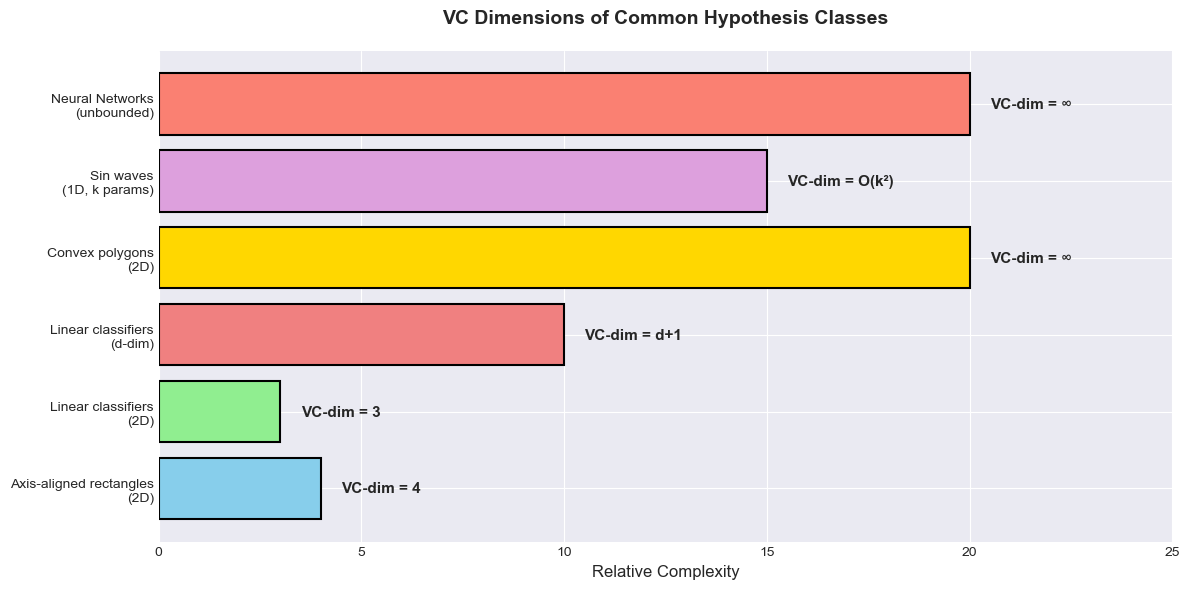

In [4]:
def plot_vc_dimensions():
    """Visualize VC dimensions of different hypothesis classes"""
    hypothesis_classes = [
        'Axis-aligned rectangles\n(2D)',
        'Linear classifiers\n(2D)',
        'Linear classifiers\n(d-dim)',
        'Convex polygons\n(2D)',
        'Sin waves\n(1D, k params)',
        'Neural Networks\n(unbounded)'
    ]
    
    vc_dims = [4, 3, 'd+1', '∞', 'O(k²)', '∞']
    colors_list = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum', 'salmon']
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars = ax.barh(hypothesis_classes, [4, 3, 10, 20, 15, 20], color=colors_list, edgecolor='black', linewidth=1.5)
    
    # Add VC dimension labels
    for i, (bar, vc) in enumerate(zip(bars, vc_dims)):
        width = bar.get_width()
        ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'VC-dim = {vc}', 
                ha='left', va='center', fontsize=11, fontweight='bold')
    
    ax.set_xlabel('Relative Complexity', fontsize=12)
    ax.set_title('VC Dimensions of Common Hypothesis Classes', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlim(0, 25)
    plt.tight_layout()
    plt.show()

plot_vc_dimensions()

## Part 2: PAC Learning

### Definition

**PAC (Probably Approximately Correct) Learning** is a framework for analyzing when and how well a learning algorithm can learn a concept.

A hypothesis class $\mathcal{H}$ is **PAC-learnable** if there exists an algorithm $A$ such that:

For any:
- Target concept $c \in \mathcal{C}$
- Distribution $D$ over the input space
- Error parameter $\epsilon > 0$ (how approximately correct)
- Confidence parameter $\delta > 0$ (how probably correct)

Given $m$ training examples where:

$$m \geq \frac{1}{\epsilon}\left(\ln|\mathcal{H}| + \ln\frac{1}{\delta}\right)$$

The algorithm $A$ outputs a hypothesis $h$ such that:

$$P[\text{error}(h) \leq \epsilon] \geq 1 - \delta$$

### Key Components

1. **Probably**: With probability at least $1-\delta$ (confidence)
2. **Approximately**: Error at most $\epsilon$ (accuracy)
3. **Correct**: The hypothesis correctly classifies new examples

### Sample Complexity

The number of training examples needed depends on:
- $\epsilon$ (desired accuracy)
- $\delta$ (desired confidence)
- Complexity of hypothesis class (e.g., $|\mathcal{H}|$ or VC dimension)

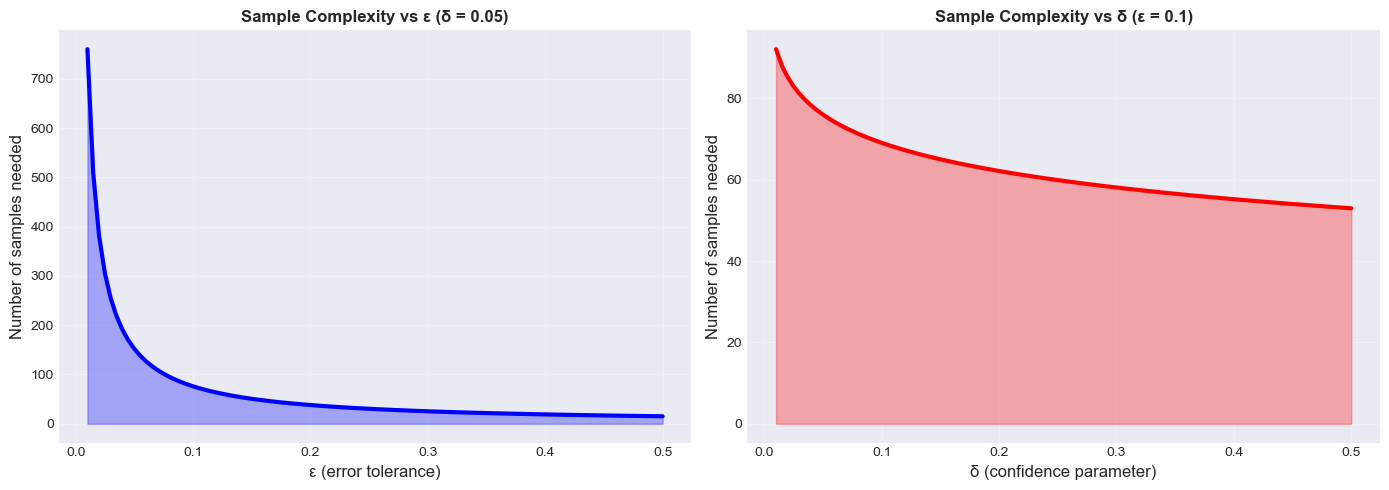

In [5]:
def plot_sample_complexity():
    """Visualize how sample complexity changes with epsilon and delta"""
    
    # Assume a finite hypothesis class with |H| = 100
    H_size = 100
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Sample complexity vs epsilon (fixed delta)
    delta = 0.05
    epsilons = np.linspace(0.01, 0.5, 100)
    samples = (1/epsilons) * (np.log(H_size) + np.log(1/delta))
    
    axes[0].plot(epsilons, samples, linewidth=3, color='blue')
    axes[0].set_xlabel('ε (error tolerance)', fontsize=12)
    axes[0].set_ylabel('Number of samples needed', fontsize=12)
    axes[0].set_title(f'Sample Complexity vs ε (δ = {delta})', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].fill_between(epsilons, 0, samples, alpha=0.3, color='blue')
    
    # Plot 2: Sample complexity vs delta (fixed epsilon)
    epsilon = 0.1
    deltas = np.linspace(0.01, 0.5, 100)
    samples = (1/epsilon) * (np.log(H_size) + np.log(1/deltas))
    
    axes[1].plot(deltas, samples, linewidth=3, color='red')
    axes[1].set_xlabel('δ (confidence parameter)', fontsize=12)
    axes[1].set_ylabel('Number of samples needed', fontsize=12)
    axes[1].set_title(f'Sample Complexity vs δ (ε = {epsilon})', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].fill_between(deltas, 0, samples, alpha=0.3, color='red')
    
    plt.tight_layout()
    plt.show()

plot_sample_complexity()

**Key Observations**:
- Smaller $\epsilon$ (more accuracy) → more samples needed
- Smaller $\delta$ (more confidence) → more samples needed
- Relationship is **logarithmic** in $1/\delta$ but **linear** in $1/\epsilon$

## Part 3: The Connection Between VC Dimension and PAC Learning

### The Fundamental Theorem of PAC Learning

This is where everything comes together! The fundamental theorem states:

**A hypothesis class $\mathcal{H}$ is PAC-learnable if and only if it has finite VC dimension.**

### Sample Complexity Bound (Using VC Dimension)

For a hypothesis class with VC dimension $d$, the number of samples needed is:

$$m \geq O\left(\frac{d + \log(1/\delta)}{\epsilon}\right)$$

More precisely:

$$m \geq \frac{c}{\epsilon}\left(d\log\frac{1}{\epsilon} + \log\frac{1}{\delta}\right)$$

where $c$ is a constant.

### Generalization Bound

With probability at least $1-\delta$, for any $h \in \mathcal{H}$:

$$\text{true error}(h) \leq \text{training error}(h) + \sqrt{\frac{d\log(m/d) + \log(1/\delta)}{m}}$$


This is a fundamental result in Statistical Learning Theory, often referred to as the **Vapnik-Chervonenkis (VC) Generalization Bound**.

 **This bound is not restricted to the realizable case.** In fact, this specific form is designed for the **Agnostic (non-realizable) PAC learning** setting.

Here is a breakdown of how to understand it:

### 1. Breaking down the components
The bound tells us that with high confidence ($1-\delta$), the performance of a model on unseen data is limited by two factors:

$$\text{True Error} \leq \underbrace{\text{Training Error}}_{\text{Empirical Risk}} + \underbrace{\sqrt{\frac{d\log(m/d) + \log(1/\delta)}{m}}}_{\text{Complexity Penalty / Estimation Error}}$$

*   **Training Error (Empirical Risk):** How well your model fits the data you actually saw.
*   **$d$ (VC Dimension):** A measure of the "flexibility" or "capacity" of your model class $\mathcal{H}$. Higher $d$ means a more complex model (like a deep neural network vs. a linear regression).
*   **$m$ (Sample Size):** The number of training examples.
*   **$\delta$ (Confidence Parameter):** The probability that this bound fails to hold. We want $\delta$ to be small (e.g., 0.05 for 95% confidence).

### 2. Why is it for the Agnostic case?
*   **In the Realizable Case:** We assume there is a hypothesis in $\mathcal{H}$ that achieves **zero** error. In that specific scenario, the bound is much tighter, typically converging at a rate of $O(1/m)$.
*   **In the Agnostic Case:** We don't assume the "perfect" model exists in our class. Because we have to account for the variance of the training error itself, the bound converges more slowly at a rate of $O(1/\sqrt{m})$. The presence of the `training error(h)` term on the right side is the "tell" that this is an agnostic bound—it accounts for models that don't reach zero error.

### 3. Intuitive Interpretation
This formula quantifies the **Fundamental Trade-off in Machine Learning**:

1.  **Complexity vs. Generalization:** If you increase the complexity ($d$) to make the `training error` go to zero, the `complexity penalty` (the square root term) grows. This is **overfitting**.
2.  **The "Law of Large Numbers" effect:** As the number of samples ($m$) grows, the complexity penalty shrinks. This confirms that more data allows you to use more complex models without losing generalization.
3.  **The Square Root Decay:** Because of the $\sqrt{1/m}$ relationship, to cut your generalization gap in half, you typically need **four times** as much data.

### Summary
This bound provides a theoretical guarantee that even if we don't know the true distribution of the data, the difference between what we see during training and what we see in the real world is bounded by the complexity of our model relative to the amount of data we have.

This tells us:
- Higher VC dimension → larger gap between training and true error
- More samples → smaller gap (generalization improves)

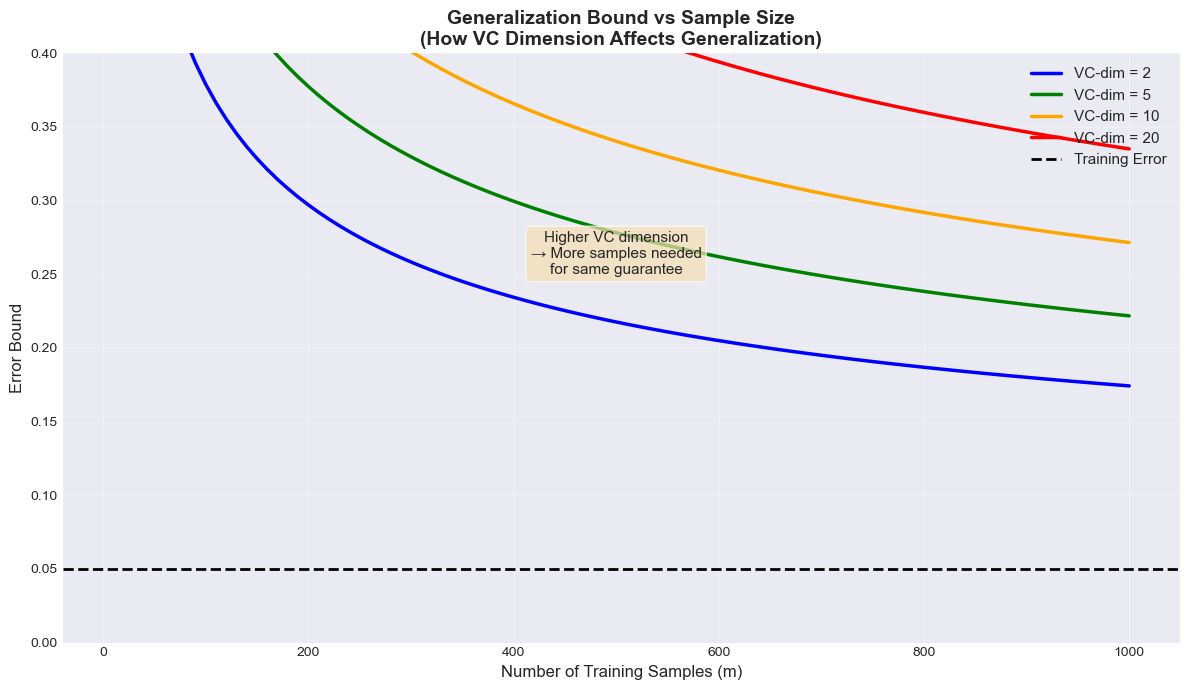

In [6]:
def plot_generalization_bound():
    """Visualize the generalization bound based on VC dimension"""
    
    m_values = np.linspace(10, 1000, 100)
    delta = 0.05
    training_error = 0.05
    
    vc_dims = [2, 5, 10, 20]
    colors = ['blue', 'green', 'orange', 'red']
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    for d, color in zip(vc_dims, colors):
        # Generalization bound
        generalization_gap = np.sqrt((d * np.log(m_values/d) + np.log(1/delta)) / m_values)
        true_error_bound = training_error + generalization_gap
        
        ax.plot(m_values, true_error_bound, linewidth=2.5, label=f'VC-dim = {d}', color=color)
    
    # Plot training error
    ax.axhline(training_error, color='black', linestyle='--', linewidth=2, label='Training Error')
    
    ax.set_xlabel('Number of Training Samples (m)', fontsize=12)
    ax.set_ylabel('Error Bound', fontsize=12)
    ax.set_title('Generalization Bound vs Sample Size\n(How VC Dimension Affects Generalization)', 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=11, loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 0.4)
    
    # Add annotation
    ax.annotate('Higher VC dimension\n→ More samples needed\nfor same guarantee', 
                xy=(500, 0.25), fontsize=11, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),
                ha='center')
    
    plt.tight_layout()
    plt.show()

plot_generalization_bound()

### Summary of the Connection

| Concept | Role | Impact |
|---------|------|--------|
| **VC Dimension** | Measures hypothesis class complexity | Higher VC-dim → need more samples |
| **PAC Learning** | Framework for learning guarantees | Requires finite VC-dim for learnability |
| **Sample Complexity** | Number of examples needed | $O(\frac{d}{\epsilon} + \frac{\log(1/\delta)}{\epsilon})$ |
| **Generalization** | Gap between training & true error | Bounded by $O(\sqrt{d/m})$ |

### Practical Implications

1. **Model Selection**: Choose models with appropriate VC dimension for your dataset size
2. **Overfitting**: High VC-dim models with few samples → overfitting
3. **Sample Efficiency**: Understanding VC-dim helps predict how much data you need
4. **Regularization**: Techniques like L1/L2 effectively reduce VC dimension

## Part 4: Practical Demonstration

Let's demonstrate these concepts with a real learning scenario:

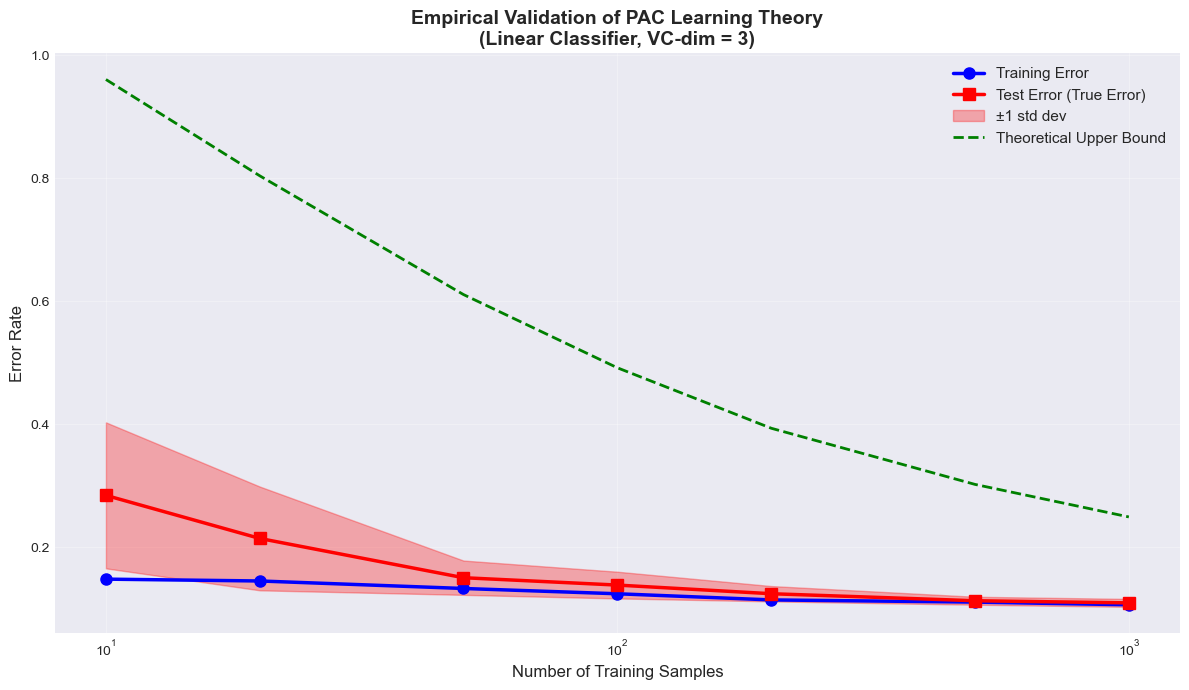


OBSERVATIONS:
1. Training error decreases as sample size increases
2. Test error (true error) converges to training error
3. Generalization gap shrinks with more samples
4. Theoretical bound is conservative but valid
5. This validates PAC learning theory predictions!


In [7]:
def generate_data(n_samples, noise=0.1):
    """Generate 2D classification data"""
    X = np.random.randn(n_samples, 2)
    # True decision boundary: x + y > 0
    y = (X[:, 0] + X[:, 1] > 0).astype(int)
    
    # Add noise
    flip_idx = np.random.rand(n_samples) < noise
    y[flip_idx] = 1 - y[flip_idx]
    
    return X, y

def empirical_pac_experiment():
    """Empirically validate PAC learning theory"""
    
    sample_sizes = [10, 20, 50, 100, 200, 500, 1000]
    n_trials = 50
    
    # Generate large test set for true error estimation
    X_test, y_test = generate_data(10000, noise=0.1)
    
    train_errors = []
    test_errors = []
    error_std = []
    
    for m in sample_sizes:
        trial_test_errors = []
        trial_train_errors = []
        
        for _ in range(n_trials):
            # Generate training data
            X_train, y_train = generate_data(m, noise=0.1)
            
            # Train linear classifier (VC-dim = 3)
            clf = SVC(kernel='linear', C=1.0)
            clf.fit(X_train, y_train)
            
            # Compute errors
            train_error = 1 - accuracy_score(y_train, clf.predict(X_train))
            test_error = 1 - accuracy_score(y_test, clf.predict(X_test))
            
            trial_train_errors.append(train_error)
            trial_test_errors.append(test_error)
        
        train_errors.append(np.mean(trial_train_errors))
        test_errors.append(np.mean(trial_test_errors))
        error_std.append(np.std(trial_test_errors))
    
    # Plot results
    fig, ax = plt.subplots(figsize=(12, 7))
    
    ax.plot(sample_sizes, train_errors, 'o-', linewidth=2.5, markersize=8, 
            label='Training Error', color='blue')
    ax.plot(sample_sizes, test_errors, 's-', linewidth=2.5, markersize=8, 
            label='Test Error (True Error)', color='red')
    
    # Add error bars
    ax.fill_between(sample_sizes, 
                     np.array(test_errors) - np.array(error_std),
                     np.array(test_errors) + np.array(error_std),
                     alpha=0.3, color='red', label='±1 std dev')
    
    # Compute theoretical bound (simplified)
    d = 3  # VC dimension of linear classifier in 2D
    delta = 0.05
    theoretical_gap = [np.sqrt((d * np.log(m/d) + np.log(1/delta)) / m) for m in sample_sizes]
    theoretical_bound = [train_errors[i] + theoretical_gap[i] for i in range(len(sample_sizes))]
    
    ax.plot(sample_sizes, theoretical_bound, '--', linewidth=2, 
            label='Theoretical Upper Bound', color='green')
    
    ax.set_xlabel('Number of Training Samples', fontsize=12)
    ax.set_ylabel('Error Rate', fontsize=12)
    ax.set_title('Empirical Validation of PAC Learning Theory\n(Linear Classifier, VC-dim = 3)', 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=11, loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("OBSERVATIONS:")
    print("="*60)
    print("1. Training error decreases as sample size increases")
    print("2. Test error (true error) converges to training error")
    print("3. Generalization gap shrinks with more samples")
    print("4. Theoretical bound is conservative but valid")
    print("5. This validates PAC learning theory predictions!")
    print("="*60)

empirical_pac_experiment()

## Part 5: Key Takeaways

### VC Dimension
✅ Measures the **capacity** of a hypothesis class  
✅ Defined by the largest set that can be **shattered**  
✅ Linear classifiers in $d$ dimensions: VC-dim = $d + 1$  
✅ Higher VC dimension = more expressive but needs more data  

### PAC Learning
✅ Framework for **probably approximately correct** learning  
✅ Provides **guarantees** on learning performance  
✅ Sample complexity depends on $\epsilon$, $\delta$, and hypothesis complexity  
✅ Connects theory to practice  

### The Connection
✅ **Fundamental Theorem**: PAC-learnable ⟺ Finite VC dimension  
✅ VC dimension determines **sample complexity**  
✅ Provides **generalization bounds**  
✅ Guides **model selection** in practice  

### Practical Guidelines

1. **Small dataset** → Choose low VC-dim models (e.g., linear)
2. **Large dataset** → Can afford higher VC-dim (e.g., deep networks)
3. **Overfitting concerns** → Use regularization to reduce effective VC-dim
4. **Sample size planning** → Use PAC bounds to estimate data needs

## Exercises

### Exercise 1: VC Dimension Calculation
What is the VC dimension of:
1. A linear classifier in 5 dimensions?
2. Axis-aligned rectangles in 3D?

### Exercise 2: Sample Complexity
You want to learn a linear classifier in 10 dimensions with:
- Error tolerance: $\epsilon = 0.05$
- Confidence: $\delta = 0.01$

How many samples do you need?

### Exercise 3: Implementation
Modify the code above to:
1. Compare linear vs polynomial kernels
2. Visualize how VC dimension affects overfitting
3. Test different noise levels

## Further Reading

- **Vapnik, V. (1998)**: Statistical Learning Theory
- **Mohri, M., Rostamizadeh, A., & Talwalkar, A. (2018)**: Foundations of Machine Learning
- **Shalev-Shwartz, S., & Ben-David, S. (2014)**: Understanding Machine Learning
- **Abu-Mostafa, Y., Magdon-Ismail, M., & Lin, H. (2012)**: Learning From Data

---

**Created with ❤️ for ML learners everywhere!**